In [1]:
import pandas as pd
from sklearn import preprocessing

from gnnad.graphanomaly import GNNAD
from gnnad.plot import plot_test_anomalies, plot_predictions, plot_sensor_error_scores

import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx

import warnings
warnings.filterwarnings("ignore", message="CUDA initialization: The NVIDIA driver on your system is too old")

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx
from IPython.display import display, HTML

import numpy as np

def normalise(X, scaler_fn):
    scaler = scaler_fn.fit(X)
    return pd.DataFrame(scaler.transform(X), index=X.index, columns = X.columns)

def pyg_to_nx(graph_dict):
    "Helper code for converting Pytorch Geometric edge indices to Networkx adjacency matrices. Keys represent epochs, and the values are a list of graph adj matrices corresponding to every batch."

    nx_dict = {key: [] for key in list(graph_dict.keys())}
    
    for k in graph_dict.keys():
        for pyg_index in graph_dict[k]:
            data = Data(edge_index=pyg_index, num_nodes=8)
            G = to_networkx(data, to_undirected=False)
            nx_dict[k].append(G)

    return nx_dict

def evolution(nx_dict, batch_id, epochs = 10):
    "Helper code for tracking the evolution of the adjacency matrix of the learned graph for a given batch."

    graph_across_epochs = []

    for i in range(epochs):
        G = nx_dict[i][batch_id]
        #adj = nx.to_numpy_array(G) # Error
        graph_across_epochs.append(G)

    return graph_across_epochs

def create_animation(graphs):
    "Function for animating the changes in the graph of a particular batch through the epochs. It can also be used for showing the differences between the graphs used by different batches. It needs to be given a list of nx graphs."
    fig, ax = plt.subplots(figsize=(6, 3))
    
    def update(num):
        ax.clear()
        G = graphs[num]
        seed = 31
        pos = nx.spring_layout(G, seed=seed)
        #nx.draw(G, pos=pos, ax=ax, with_labels=True, node_size = 1500, node_color = 'skyblue')
        nx.draw(G, pos=pos, ax=ax, with_labels=True, node_size = 500, linewidths=2, node_color = "tab:red", alpha = 0.9, edge_color = "tab:gray", font_size=8, font_color="whitesmoke")
        ax.set_title(f"Epoch {num+1}/{len(graphs)}")

    plt.close()
    ani = animation.FuncAnimation(fig, update, frames=len(graphs), interval=1500, repeat=True)
    return ani

def adjacency_comparison(graphs):
    " Simple check to compare the adjacency matrices of the graphs in the given list. "

    first_adj = nx.to_numpy_array(graphs[0], dtype = int)
    j = 1

    # Comparison of adj matrices
    for i, G in enumerate(graphs[1:], 1):
        adj = nx.to_numpy_array(G, dtype = int)
        if not np.array_equal(first_adj, adj):
            print(first_adj)
            print()
            print(adj)
            print()
            print(f"Graph {i+1} is different from the Graph {j}.")
            print()
            first_adj = adj
            j = i + 1
            #return False

    #return True

In [2]:
# read in training data
X_train = pd.read_csv('./examples/herbert_train.csv', index_col=0)
X_train.index = pd.to_datetime(X_train.index)

# read in test data
X_tmp = pd.read_csv('./examples/herbert_test.csv', index_col=0)
X_tmp.index = pd.to_datetime(X_tmp.index)
X_test = X_tmp.iloc[:,:8]
y_test = X_tmp.iloc[:,8:].apply(any, axis=1)

# normalise
X_test = normalise(X_test, preprocessing.StandardScaler())
X_train = normalise(X_train, preprocessing.StandardScaler())

# create ANOOMS dict for plotting
ANOMS = {'type1': {}}
X_test_anoms = X_tmp.iloc[:,8:]

for i in range(len(X_test_anoms.columns)):
    anom_col_name = X_test_anoms.columns[i]
    sensor_col_name = X_test.columns[i]
    anom_idxs = X_test_anoms[anom_col_name][X_test_anoms[anom_col_name]].index

    if len(anom_idxs) > 0:
        ANOMS['type1'][sensor_col_name] = anom_idxs

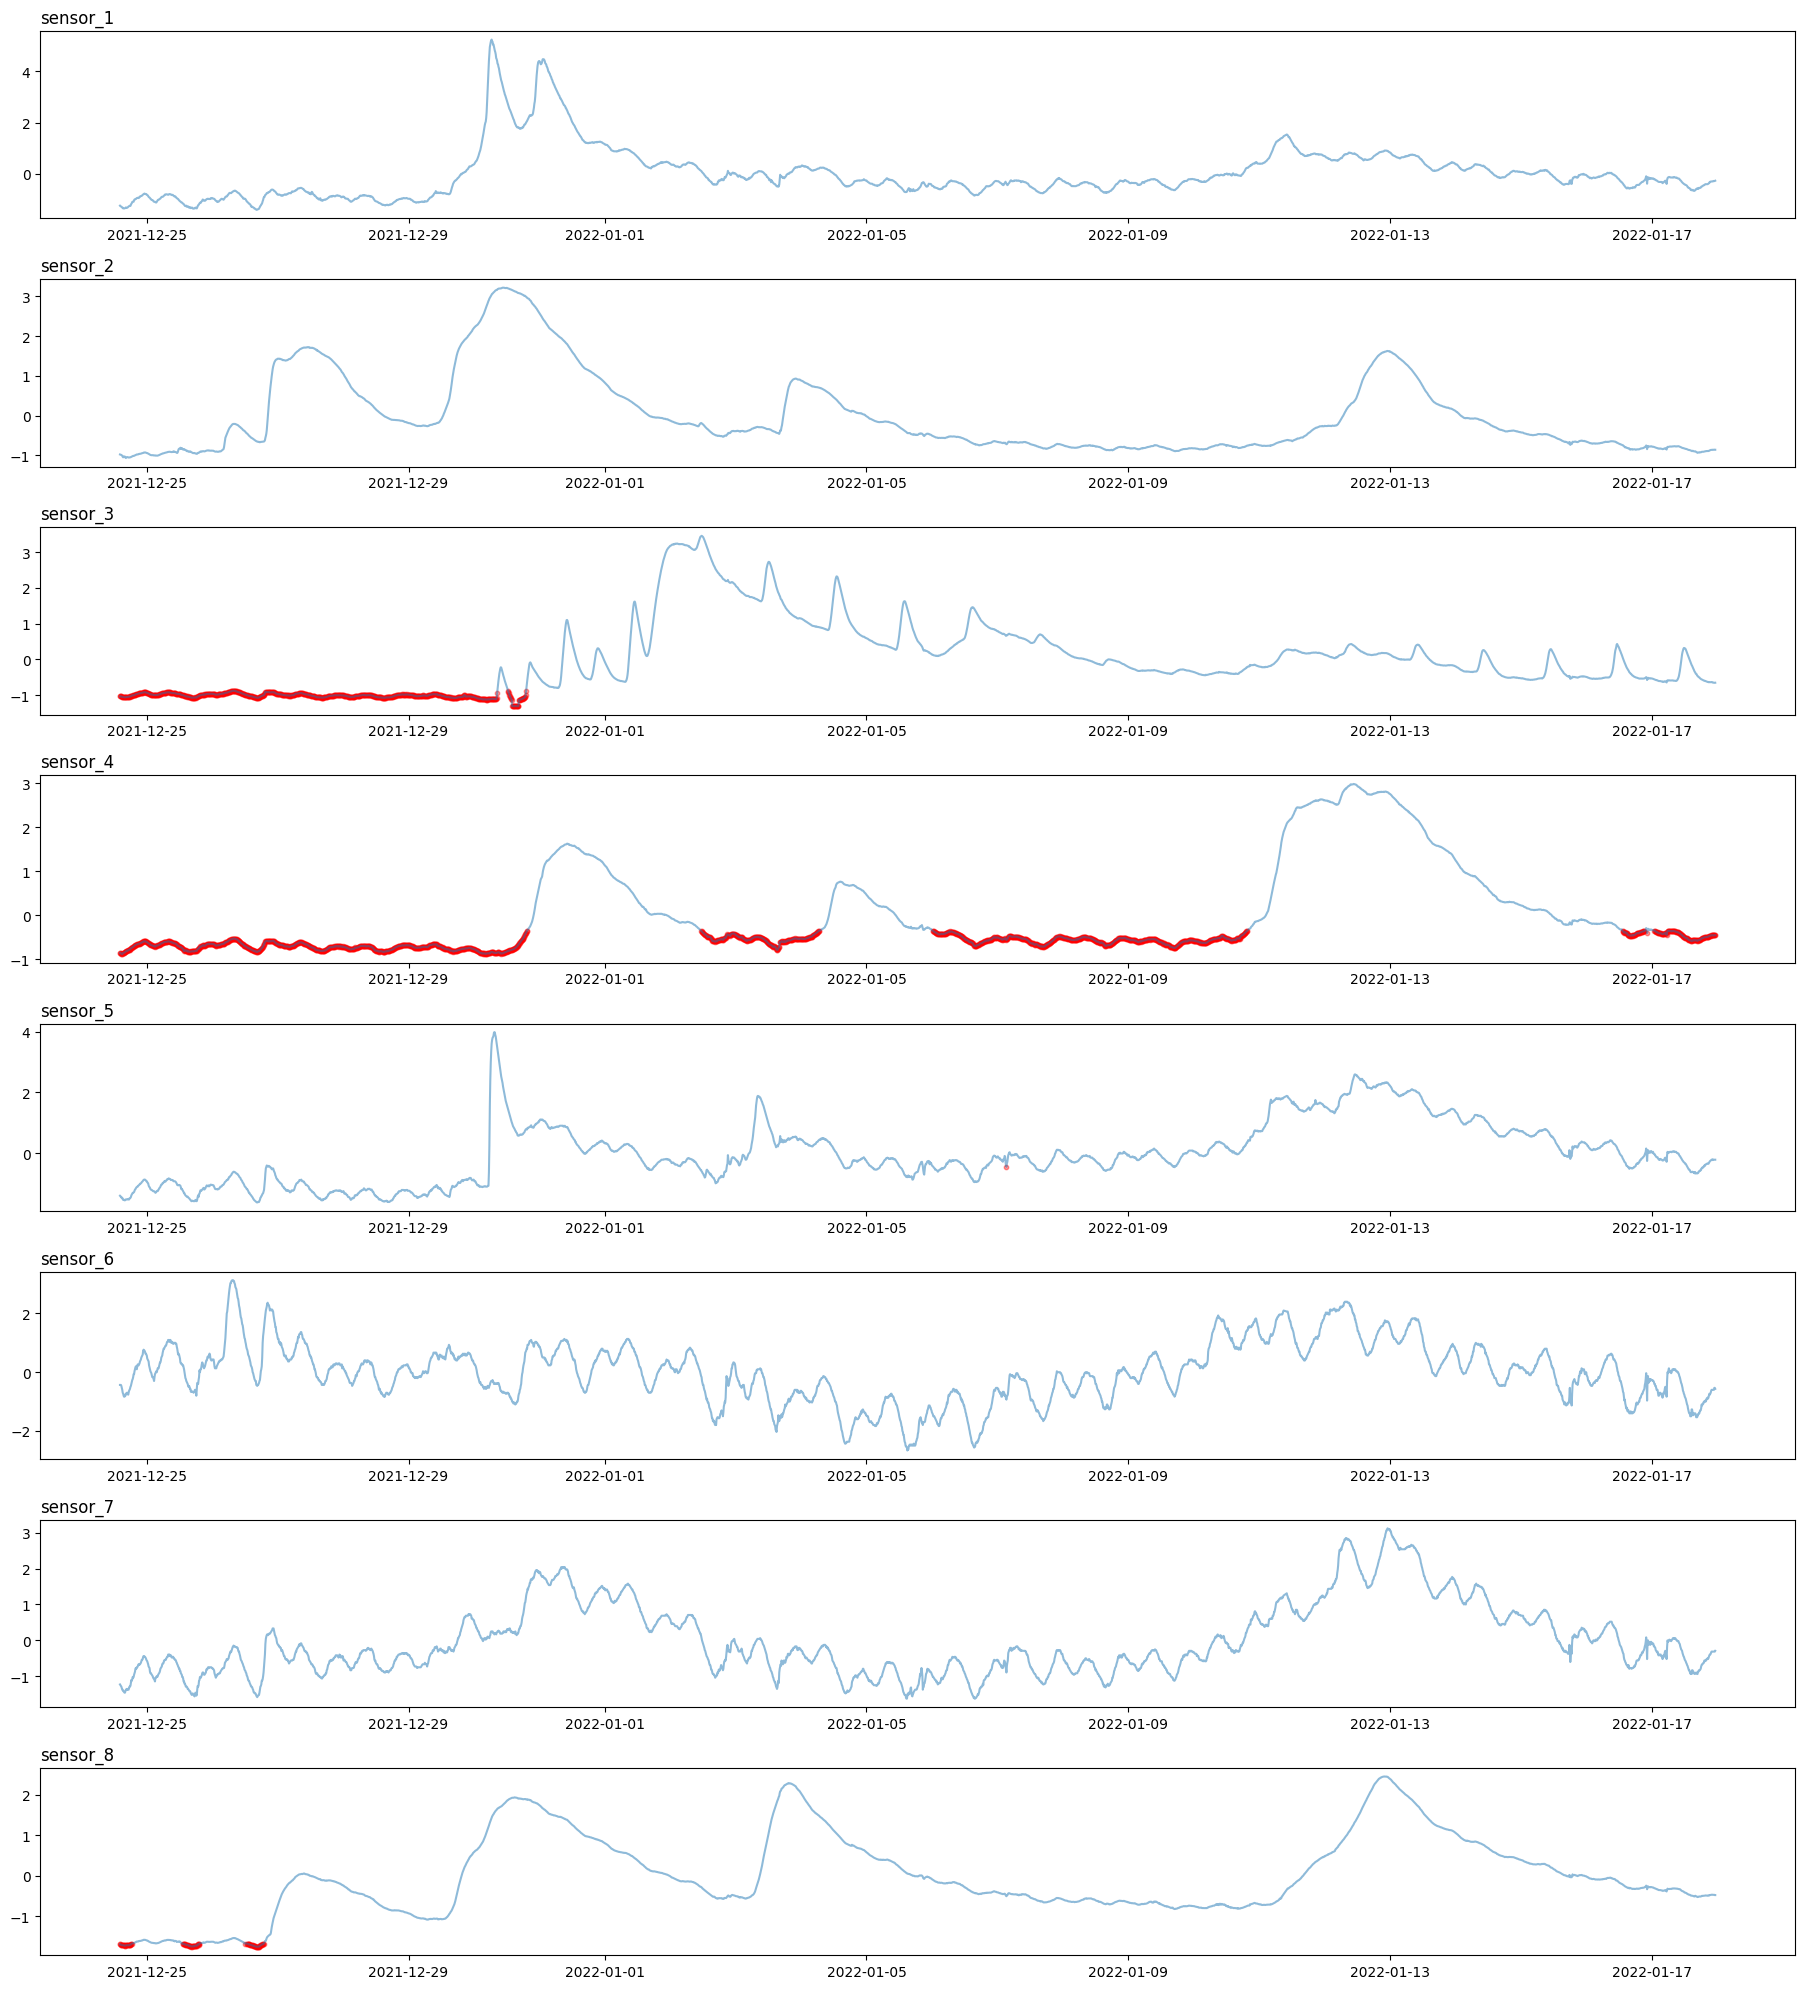

In [3]:
# plot input data
plot_test_anomalies(X_test, ANOMS)

In [4]:
print('train size:', X_train.shape)
print('test size:', X_test.shape)
print('sliding window count:', (12745 - 200) / 5 + 1) # (Row count - sliding window size) / sliding stride size + 1
print('Total number of batches:', (((12745 + 3499) - 200) / 5 + 1) / 128)

train size: (12745, 8)
test size: (3499, 8)
sliding window count: 2510.0
Total number of batches: 25.0765625


In [5]:
# run model

"""
Default Hyperparameters of GNNAD

batch: int = 128,
epoch: int = 100,
slide_win: int = 15,
embed_dim: int = 64,
slide_stride: int = 5,
random_seed: int = 0,
out_layer_num: int = 1,
out_layer_inter_dim: int = 256,
decay: float = 0,
validate_ratio: float = 0.1,
topk: int = 20,
device: str = "cpu",
save_model_name: str = "",
early_stop_win: int = 15,
lr: float = 0.001,
shuffle_train: bool = True,
threshold_type: str = None,
suppress_print: bool = False,
smoothen_error: bool = True,
use_deterministic: bool = False
"""

model = GNNAD(threshold_type="max_validation", shuffle_train = False, topk=3, slide_win=200, epoch = 2)
fitted_model = model.fit(X_train, X_test, y_test)

Size of input x to gnn: torch.Size([128, 8, 200])
Size of batch: 128
Shape of node embeddings: torch.Size([8, 64])
Shape of node embeddings(replicated for batch): torch.Size([1024, 64])
Size of input x to gnn: torch.Size([128, 8, 200])
Size of batch: 128
Shape of node embeddings: torch.Size([8, 64])
Shape of node embeddings(replicated for batch): torch.Size([1024, 64])
Size of input x to gnn: torch.Size([128, 8, 200])
Size of batch: 128
Shape of node embeddings: torch.Size([8, 64])
Shape of node embeddings(replicated for batch): torch.Size([1024, 64])
Size of input x to gnn: torch.Size([128, 8, 200])
Size of batch: 128
Shape of node embeddings: torch.Size([8, 64])
Shape of node embeddings(replicated for batch): torch.Size([1024, 64])
Size of input x to gnn: torch.Size([128, 8, 200])
Size of batch: 128
Shape of node embeddings: torch.Size([8, 64])
Shape of node embeddings(replicated for batch): torch.Size([1024, 64])
Size of input x to gnn: torch.Size([128, 8, 200])
Size of batch: 128
S

In [24]:
train_graph, val_graph, test_graph = model.get_learned_graph()

for k, v in train_graph.items():
    print(f'Epoch {k}, number of batches {len(v)}')

train_nx = pyg_to_nx(train_graph)

Epoch 0, number of batches 18
Epoch 1, number of batches 18
Epoch 2, number of batches 18
Epoch 3, number of batches 18
Epoch 4, number of batches 18
Epoch 5, number of batches 18
Epoch 6, number of batches 18
Epoch 7, number of batches 18
Epoch 8, number of batches 18
Epoch 9, number of batches 18
Epoch 10, number of batches 18
Epoch 11, number of batches 18
Epoch 12, number of batches 18
Epoch 13, number of batches 18
Epoch 14, number of batches 18
Epoch 15, number of batches 18
Epoch 16, number of batches 18
Epoch 17, number of batches 18
Epoch 18, number of batches 18
Epoch 19, number of batches 18
Epoch 20, number of batches 18
Epoch 21, number of batches 18
Epoch 22, number of batches 18
Epoch 23, number of batches 18
Epoch 24, number of batches 18
Epoch 25, number of batches 18
Epoch 26, number of batches 18
Epoch 27, number of batches 18
Epoch 28, number of batches 18
Epoch 29, number of batches 18
Epoch 30, number of batches 18
Epoch 31, number of batches 18
Epoch 32, number o

In [26]:
first_batch_graphs = evolution(train_nx, batch_id=0, epochs=36)
second_batch_graphs = evolution(train_nx, batch_id=1, epochs=36)

In [27]:
# Let's see if the graph of the first batch changes or stays the same through 10 epochs.

ani = create_animation(first_batch_graphs)
display(HTML(ani.to_jshtml()))
ani.save('graph_evolution_firstbatch_100epoch.gif', writer='pillow')
plt.show()

In [28]:
adjacency_comparison(first_batch_graphs)

[[1 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 1 0]
 [1 0 1 1 0 0 0 0]
 [0 0 0 1 1 0 0 0]
 [0 1 1 1 1 0 0 1]
 [1 0 0 0 0 1 1 1]
 [0 1 0 0 0 0 1 0]
 [0 0 1 0 1 1 0 1]]

[[1 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 1 0]
 [1 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0]
 [0 1 1 1 1 0 0 1]
 [1 0 0 0 0 1 1 1]
 [0 1 0 0 0 1 1 0]
 [0 0 1 0 1 1 0 1]]

Graph 3 is different from the Graph 1.

[[1 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 1 0]
 [1 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0]
 [0 1 1 1 1 0 0 1]
 [1 0 0 0 0 1 1 1]
 [0 1 0 0 0 1 1 0]
 [0 0 1 0 1 1 0 1]]

[[1 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 1 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0]
 [0 1 1 1 1 0 0 1]
 [1 0 0 0 0 1 1 1]
 [0 1 0 0 0 1 1 0]
 [1 0 1 0 1 1 0 1]]

Graph 10 is different from the Graph 3.

[[1 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 1 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0]
 [0 1 1 1 1 0 0 1]
 [1 0 0 0 0 1 1 1]
 [0 1 0 0 0 1 1 0]
 [1 0 1 0 1 1 0 1]]

[[1 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 1 0]
 [0 0 1 0 0 0 0 0]
 [0 1 0 1 1 0 0 0]
 [0 1 1 1 1 0 0 1]
 [1 0 0 0 0 1 1 1]
 [0 0 0 0 0 1 1 0]
 [1 0 1 0 1 1 0 

In [29]:
# Let's see if the graph of the second batch changes or stays the same through 10 epochs.

ani = create_animation(second_batch_graphs)
display(HTML(ani.to_jshtml()))
ani.save('graph_evolution_secondbatch_100epoch.gif', writer='pillow')
plt.show()

In [30]:
adjacency_comparison(second_batch_graphs)

[[1 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 1 0]
 [1 0 1 1 0 0 0 0]
 [0 0 0 1 1 0 0 0]
 [0 1 1 1 1 0 0 1]
 [1 0 0 0 0 1 1 1]
 [0 1 0 0 0 0 1 0]
 [0 0 1 0 1 1 0 1]]

[[1 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 1 0]
 [1 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0]
 [0 1 1 1 1 0 0 1]
 [1 0 0 0 0 1 1 1]
 [0 1 0 0 0 1 1 0]
 [0 0 1 0 1 1 0 1]]

Graph 3 is different from the Graph 1.

[[1 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 1 0]
 [1 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0]
 [0 1 1 1 1 0 0 1]
 [1 0 0 0 0 1 1 1]
 [0 1 0 0 0 1 1 0]
 [0 0 1 0 1 1 0 1]]

[[1 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 1 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0]
 [0 1 1 1 1 0 0 1]
 [1 0 0 0 0 1 1 1]
 [0 1 0 0 0 1 1 0]
 [1 0 1 0 1 1 0 1]]

Graph 10 is different from the Graph 3.

[[1 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 1 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0]
 [0 1 1 1 1 0 0 1]
 [1 0 0 0 0 1 1 1]
 [0 1 0 0 0 1 1 0]
 [1 0 1 0 1 1 0 1]]

[[1 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 1 0]
 [0 0 1 0 0 0 0 0]
 [0 1 0 1 1 0 0 0]
 [0 1 1 1 1 0 0 1]
 [1 0 0 0 0 1 1 1]
 [0 0 0 0 0 1 1 0]
 [1 0 1 0 1 1 0 

In [125]:
second_epoch_graphs = train_nx[1]
first_epoch_graphs = train_nx[0]

In [138]:
adjacency_comparison(first_epoch_graphs) # Looks like all the graphs are the same for every batch in first epoch.

In [139]:
ani = create_animation(first_epoch_graphs)
display(HTML(ani.to_jshtml()))
ani.save('graphs_in_firstepoch.gif', writer='pillow')
plt.show()

In [126]:
adjacency_comparison(second_epoch_graphs)

[[1 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 1 0]
 [1 0 1 1 0 0 0 0]
 [0 0 0 1 1 0 0 0]
 [0 1 1 1 1 0 0 1]
 [1 0 0 0 0 1 1 1]
 [0 1 0 0 0 0 1 0]
 [0 0 1 0 1 1 0 1]]

[[1 0 0 0 0 1 0 0]
 [0 1 0 1 0 0 1 0]
 [1 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0]
 [0 1 1 1 1 0 0 1]
 [1 0 0 0 0 1 1 1]
 [0 1 0 0 0 0 1 0]
 [0 0 1 0 1 1 0 1]]

Graph 11 is different from the Graph 1.



In [127]:
def create_animation(graphs):
    "Function for animating the changes in the graph of a particular batch through the epochs. It can also be used for showing the differences between the graphs used by different batches. It needs to be given a list of nx graphs."
    fig, ax = plt.subplots(figsize=(6, 3))
    
    def update(num=0):
        ax.clear()
        G = graphs[num]
        seed = 31
        pos = nx.spring_layout(G, seed=seed)
        nx.draw(G, pos=pos, ax=ax, with_labels=True, node_size = 500, linewidths=2, node_color = "tab:red", alpha = 0.9, edge_color = "tab:gray", font_size=8, font_color="whitesmoke")
        ax.set_title(f"Epoch(or batch) {num+1}/{len(graphs)}")

    plt.close()
    ani = animation.FuncAnimation(fig, update, frames=len(graphs), interval=1500, repeat=True)
    return ani

In [128]:
ani = create_animation(second_epoch_graphs)
display(HTML(ani.to_jshtml()))
ani.save('graphs_in_secondepoch.gif', writer='pillow')
plt.show()

In the second epoch, the graphs are the same for batches 1-10 and 11-18.

In [136]:
# Lets see how 11th batch evolves over time.

eleventh_batch_graphs = evolution(train_nx, batch_id=10, epochs=10)
adjacency_comparison(eleventh_batch_graphs)

[[1 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 1 0]
 [1 0 1 1 0 0 0 0]
 [0 0 0 1 1 0 0 0]
 [0 1 1 1 1 0 0 1]
 [1 0 0 0 0 1 1 1]
 [0 1 0 0 0 0 1 0]
 [0 0 1 0 1 1 0 1]]

[[1 0 0 0 0 1 0 0]
 [0 1 0 1 0 0 1 0]
 [1 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0]
 [0 1 1 1 1 0 0 1]
 [1 0 0 0 0 1 1 1]
 [0 1 0 0 0 0 1 0]
 [0 0 1 0 1 1 0 1]]

Graph 2 is different from the Graph 1.

[[1 0 0 0 0 1 0 0]
 [0 1 0 1 0 0 1 0]
 [1 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0]
 [0 1 1 1 1 0 0 1]
 [1 0 0 0 0 1 1 1]
 [0 1 0 0 0 0 1 0]
 [0 0 1 0 1 1 0 1]]

[[1 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 1 0]
 [1 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0]
 [0 1 1 1 1 0 0 1]
 [1 0 0 0 0 1 1 1]
 [0 1 0 0 0 1 1 0]
 [0 0 1 0 1 1 0 1]]

Graph 3 is different from the Graph 2.

[[1 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 1 0]
 [1 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0]
 [0 1 1 1 1 0 0 1]
 [1 0 0 0 0 1 1 1]
 [0 1 0 0 0 1 1 0]
 [0 0 1 0 1 1 0 1]]

[[1 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 1 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0]
 [0 1 1 1 1 0 0 1]
 [1 0 0 0 0 1 1 1]
 [0 1 0 0 0 1 1 0]
 [1 0 1 0 1 1 0 1

In [137]:
ani = create_animation(eleventh_batch_graphs)
display(HTML(ani.to_jshtml()))
ani.save('graph_evolution_eleventhbatch.gif', writer='pillow')
plt.show()

(Note: In networkx, directed graph adj matrices are read as that if there is an edge from i to j, we put 1. i is row index and j is column index.)

In [7]:
# model summary
fitted_model.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1                   [-1, 64]             512
         Embedding-2                   [-1, 64]             512
            Linear-3                   [-1, 64]          12,800
    SumAggregation-4                [-1, 1, 64]               0
        GraphLayer-5                   [-1, 64]              64
       BatchNorm1d-6                   [-1, 64]             128
              ReLU-7                   [-1, 64]               0
          GNNLayer-8                   [-1, 64]               0
         Embedding-9                   [-1, 64]             512
      BatchNorm1d-10                [-1, 64, 8]             128
          Dropout-11                [-1, 8, 64]               0
           Linear-12                 [-1, 8, 1]              65
         OutLayer-13                 [-1, 8, 1]               0
Total params: 14,721
Trainable params: 

In [8]:
# GDN+, sensor thresholds
preds = fitted_model.sensor_threshold_preds(tau = 99)
fitted_model.print_eval_metrics(preds)


recall: 13.4
precision: 35.3
accuracy: 38.2
specificity: 69.3
f1: 19.4


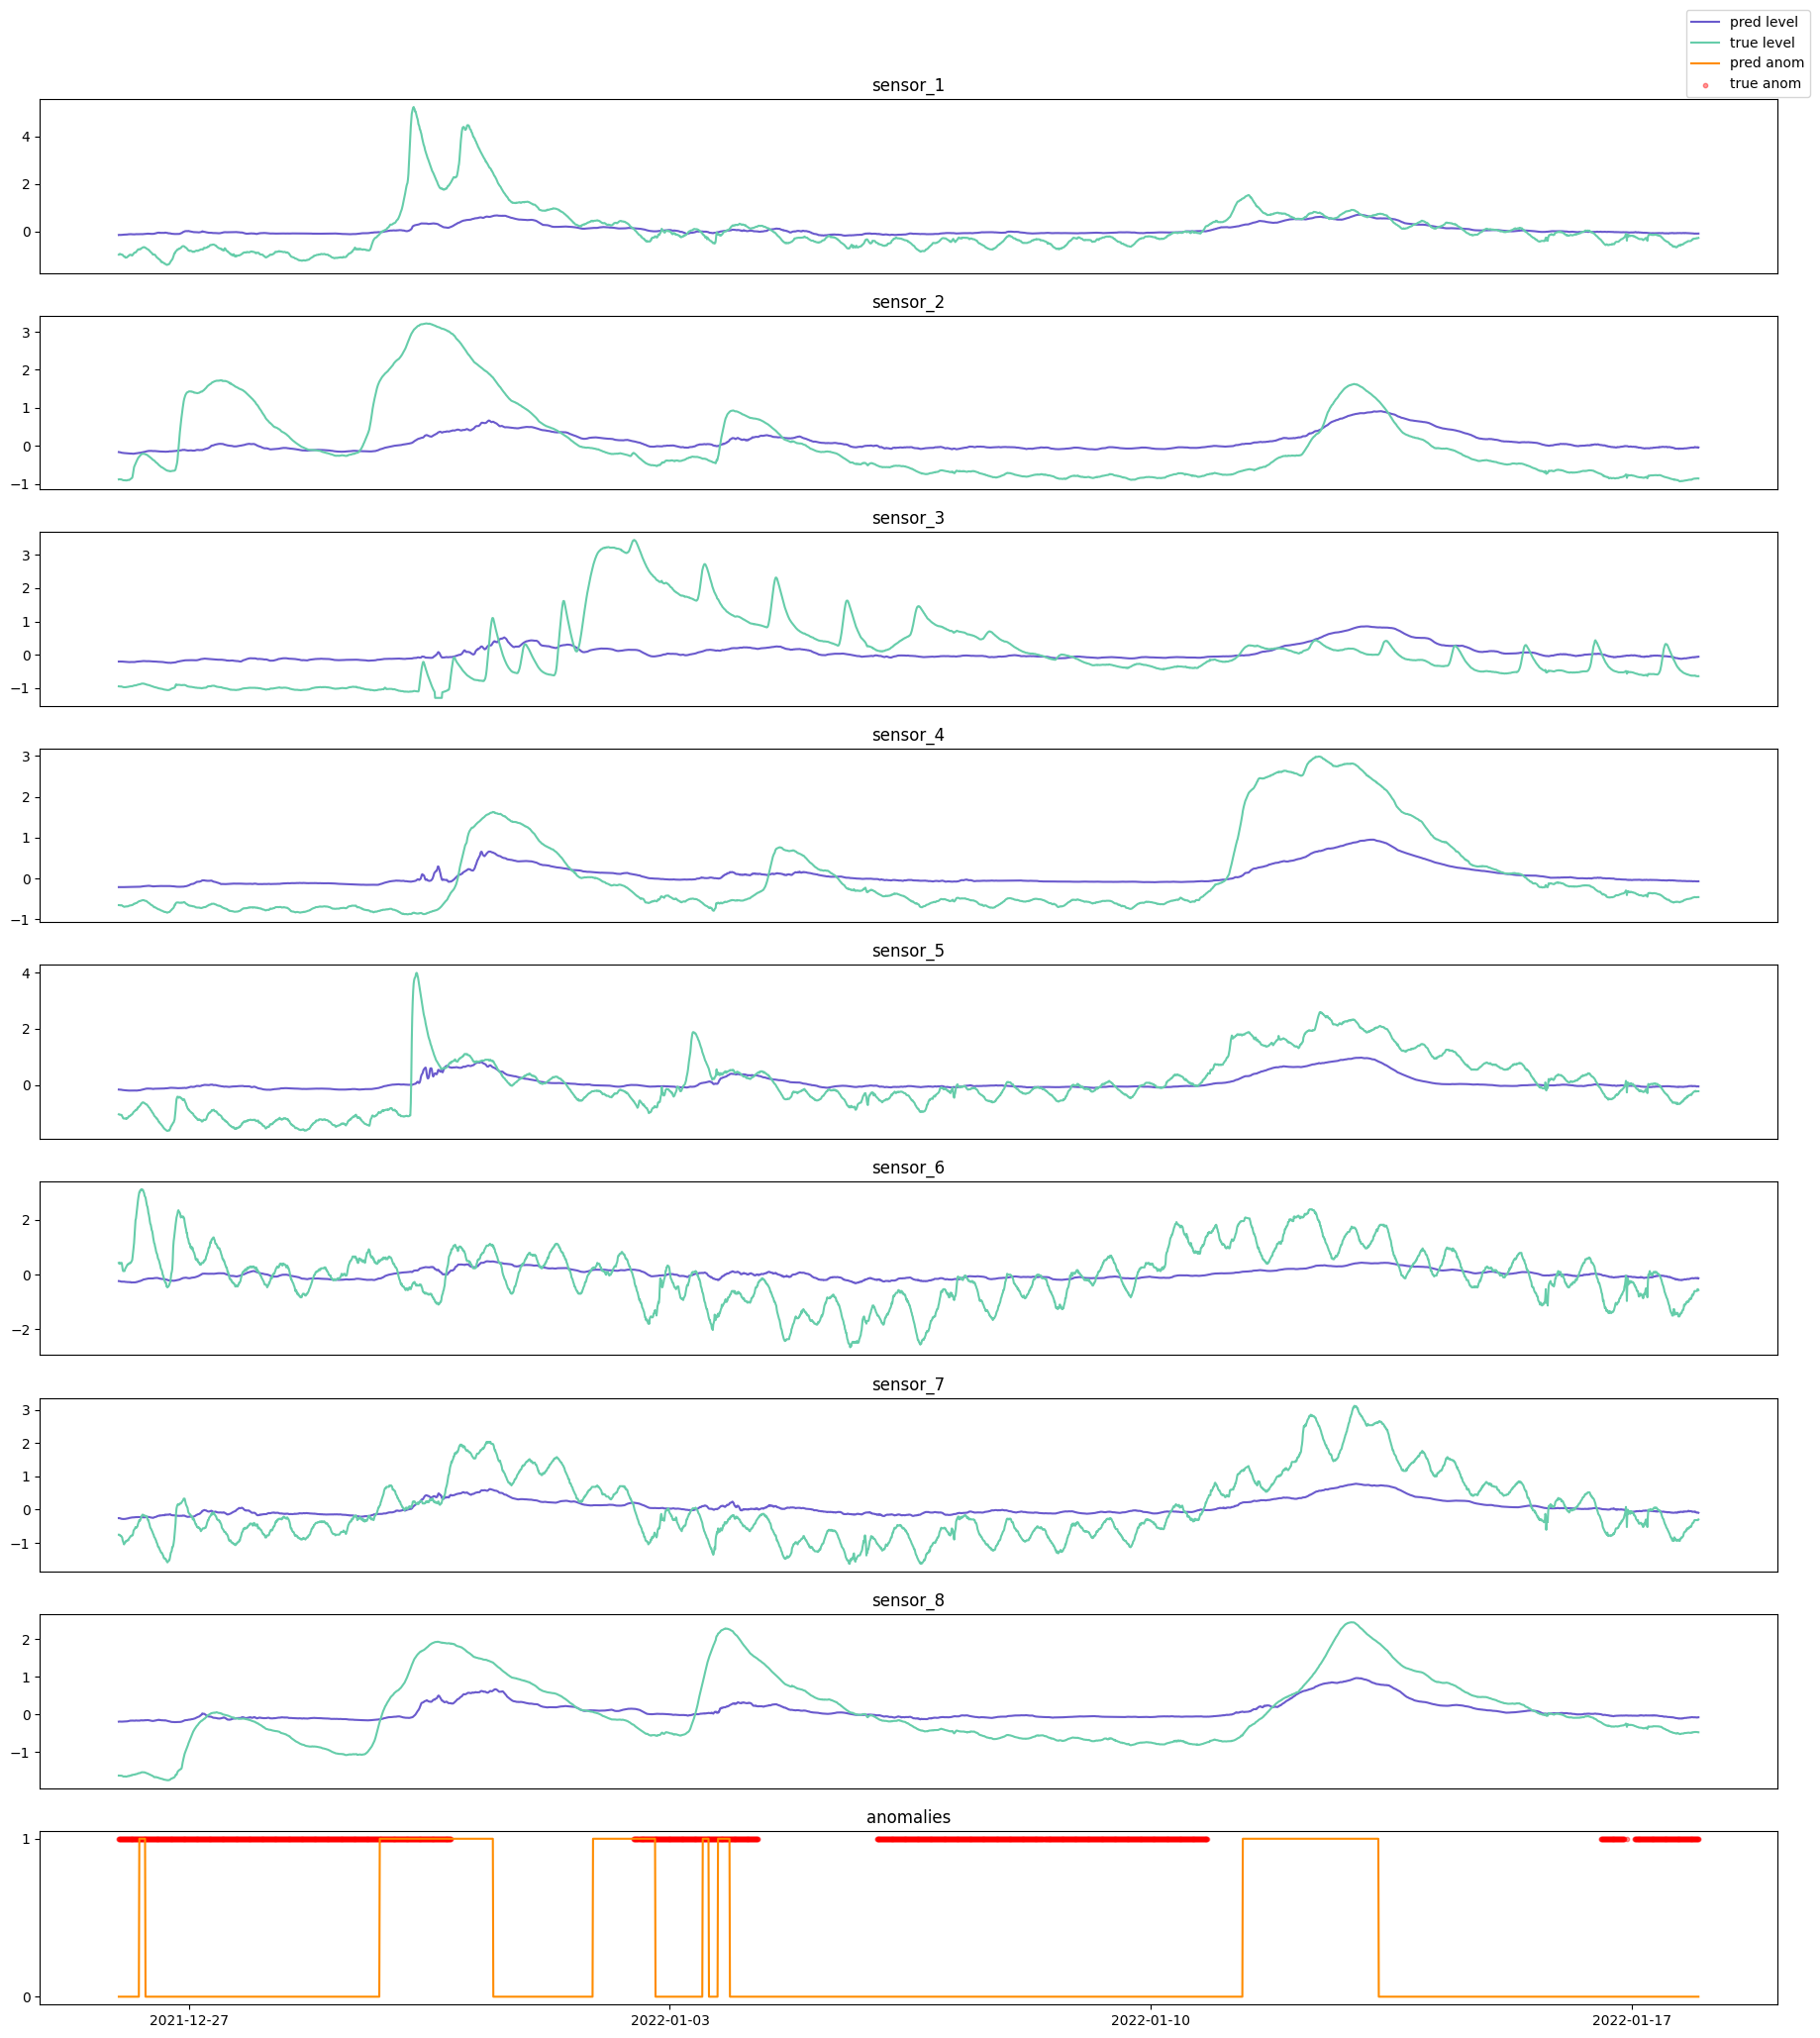

In [9]:
# plot predictions
plot_predictions(fitted_model, X_test, ANOMS, preds = preds, figsize=(20, 20))


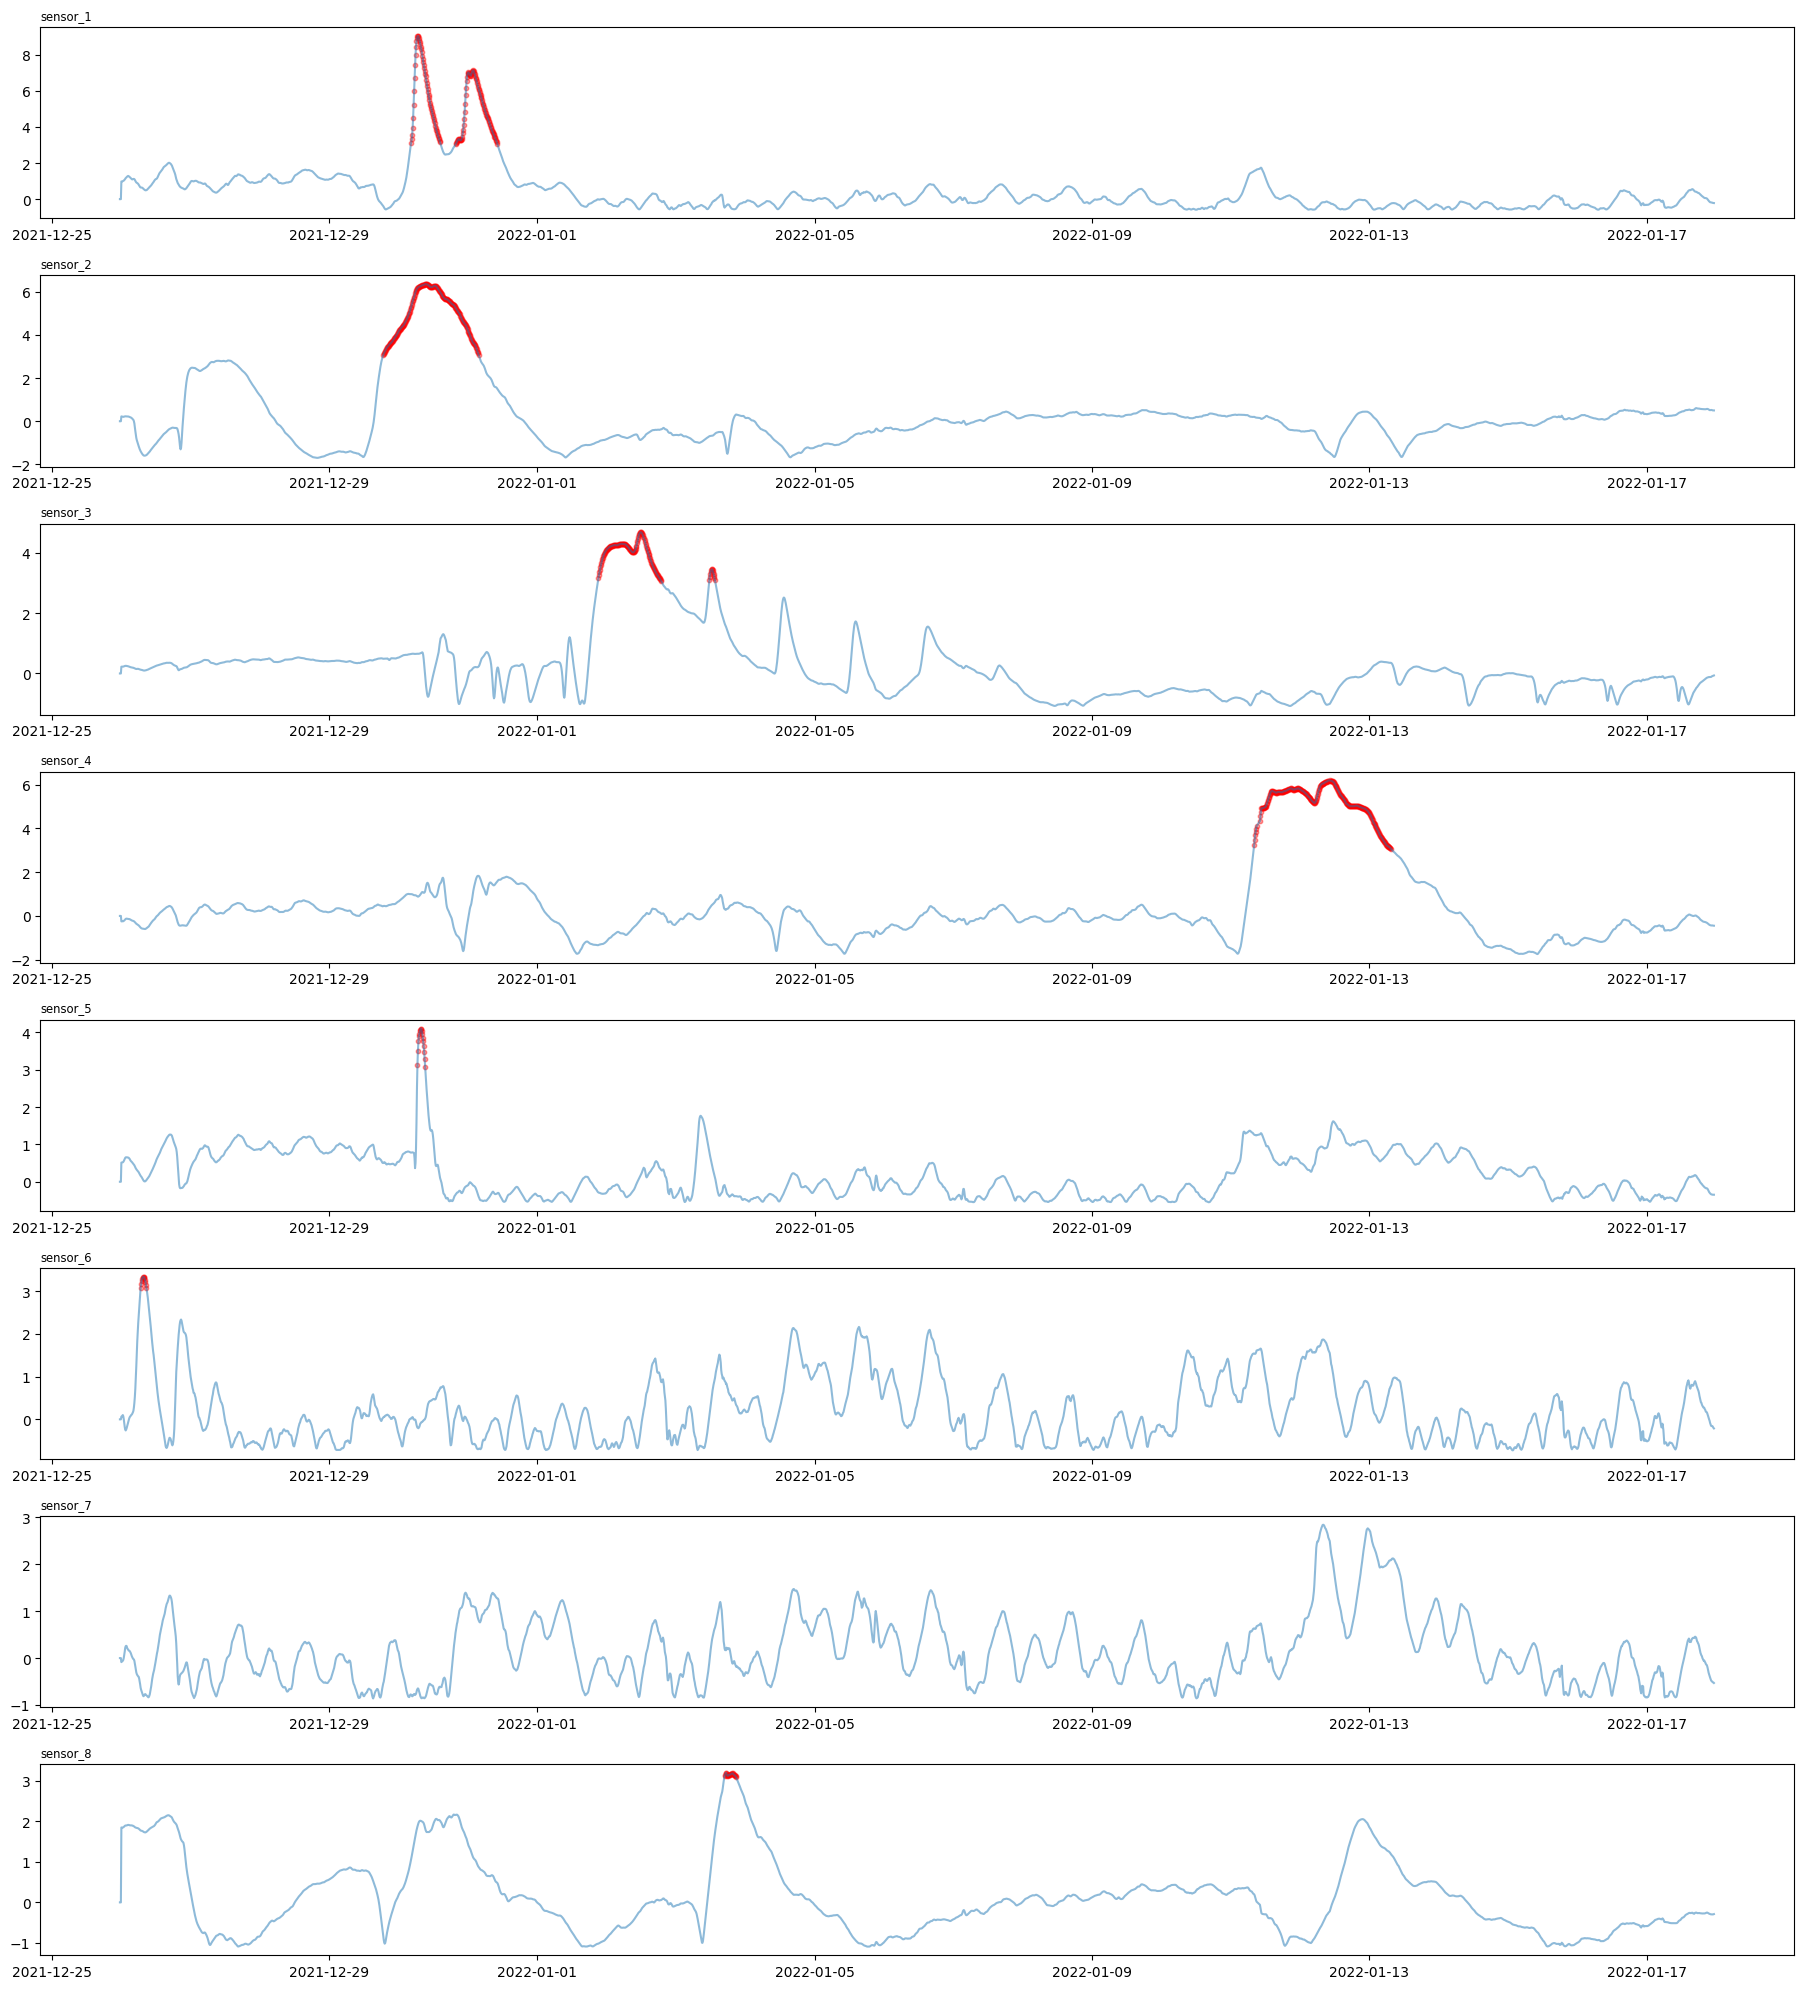

In [10]:
plot_sensor_error_scores(fitted_model, X_test)